In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

import obspy
from obspy.clients.fdsn import Client
from matplotlib.colors import LogNorm
from obspy import Stream
from obspy.geodetics import gps2dist_azimuth

#!pip install mp_toolkits.basemap
from mpl_toolkits.basemap import Basemap #<< works with python 3.11.5

ap = Client('IRIS')

# we will start with just LH stations, but if this is kind of terrible talk with Son about adding more
inv_LH = ap.get_stations(network='*', station="BEAR,DNTW,SILY,THUR,UNGL,UPTW,WAIS,WHIT", level='response', channel='LHZ', starttime=obspy.UTCDateTime(2013,1,1,1),
                      endtime = obspy.UTCDateTime(2014,1,1,1), maxlatitude=-63)
print(inv_LH)

sta_lats = []
sta_lons = []
sta_names = []
for i in range(len(inv_LH)):
    for j in range(len(inv_LH[i])):
        sta_lats.append(inv_LH[i][j].latitude)
        sta_lons.append(inv_LH[i][j].longitude)
        sta_names.append(f"{inv_LH[i].code}.{inv_LH[i][j].code}")
print('Number of stations:', len(sta_lats))

Inventory created at 2025-10-19T10:19:13.393600Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2013-01-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			YT
		Stations (8):
			YT.BEAR (Bear Peninsula)
			YT.DNTW (Lower Thwaites Glacier)
			YT.SILY (SILY)
			YT.THUR (Thurston Island)
			YT.UNGL (Union Glacier)
			YT.UPTW (UPTW)
			YT.WAIS (WAIS)
			YT.WHIT (Whitmore Mountains)
		Channels (9):
			YT.BEAR..LHZ, YT.DNTW..LHZ, YT.SILY..LHZ, YT.THUR..LHZ, 
			YT.UNGL..LHZ, YT.UPTW..LHZ, YT.WAIS..LHZ, YT.WHIT..LHZ (2x)
Number of stations: 8


In [2]:
# indexing the stations to a single variable thats length 234 at the moment

stations_flat = []
networks_flat = []
for i in range(len(inv_LH)):
    for j in range(len(inv_LH[i])):
        stations_flat.append(inv_LH[i][j].code)
        networks_flat.append(inv_LH[i].code)
        
print(len(stations_flat))
len(networks_flat)

8


8

In [3]:
station_infos = list(zip(sta_lats, sta_lons, networks_flat, stations_flat))

station_infos

[(-74.5476, -111.8511, 'YT', 'BEAR'),
 (-76.4512, -107.7769, 'YT', 'DNTW'),
 (-77.1332, -125.966, 'YT', 'SILY'),
 (-72.5301, -97.5606, 'YT', 'THUR'),
 (-79.7746, -82.524, 'YT', 'UNGL'),
 (-77.5781, -109.0374, 'YT', 'UPTW'),
 (-79.4181, -111.7779, 'YT', 'WAIS'),
 (-82.6823, -104.3867, 'YT', 'WHIT')]

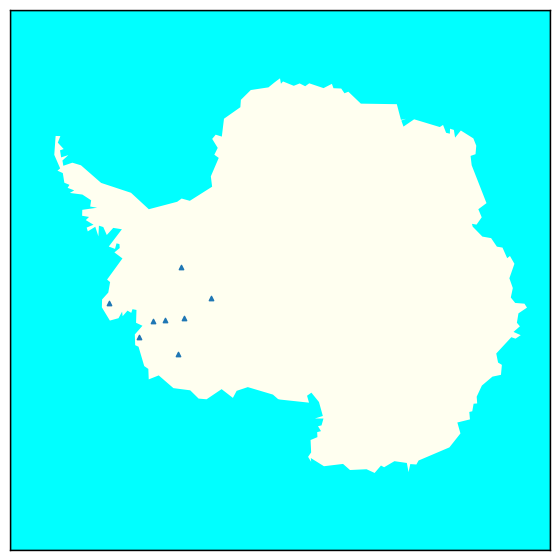

In [4]:
# plotting the stations overall

fig = plt.figure(figsize=(9, 6))
xa = fig.add_axes([0.90, 0.90, 0.90, 0.90])

ma = Basemap(epsg='3031', width=6e6, height=6e6, ax=xa)
wa, ha = ma.xmax, ma.ymax

ma.drawmapboundary(fill_color='aqua')
ma.fillcontinents(color='ivory', lake_color='aqua')

son = ma.scatter(sta_lons, sta_lats, s=10, marker='^', latlon=True)

plt.show()

In [5]:
# importing Son's events

son = pd.read_csv(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\Pham2025_submitted\TableS1.csv")
# son = son[son['quality_group'] == 'A'] # filtering to only the quality A events

lats = son['relocated_latitude'].tolist()
lons = son['relocated_longitude'].tolist()
mags = son['Ms_BB'].tolist()
times = son['relocated_time'].tolist()
#qualities = son['quality_group'].tolist()

son_date_format = '%Y-%m-%dT%H:%M:%S.000000Z'

years = []
months = []
days = []
for i in range(len(times)):
    years.append(int(datetime.strptime(times[i], son_date_format).strftime('%Y')))
    months.append(int(datetime.strptime(times[i], son_date_format).strftime('%m')))
    days.append(int(datetime.strptime(times[i], son_date_format).strftime('%d')))

print(son)

           evcode  relocated_latitude  relocated_longitude  \
0    201004081006              -76.02              -106.56   
1    201005081749              -74.98              -101.52   
2    201006010156              -80.65               159.30   
3    201006171002              -75.21              -107.85   
4    201012040308                 NaN                  NaN   
..            ...                 ...                  ...   
363  202305270743              -75.34              -101.35   
364  202306100843              -75.67              -108.93   
365  202306221811              -75.38              -107.21   
366  202307190438              -75.51              -106.52   
367  202310131009              -75.72              -106.78   

                  relocated_time  max_cc  eff_nstations  Ms_BB  \
0    2010-04-08T10:06:34.000000Z    0.78           1.61   2.37   
1    2010-05-08T17:49:08.000000Z    0.76           2.13   2.43   
2    2010-06-01T01:56:43.000000Z    0.77           6.85  

In [6]:
# isolating the specific events

event_times = ['2013-11-09T07:24:51.000000Z', 
               '2013-11-10T19:16:40.000000Z',
               '2013-11-15T13:24:15.000000Z',
               '2013-11-19T12:46:17.000000Z',
               '2013-11-21T07:28:51.000000Z',
               '2013-11-23T04:22:04.000000Z']


events = []

for i in range(len(times)):
    if times[i] in event_times:
        event_details = [lats[i], lons[i], times[i], mags[i], years[i] + months[i]/12 + days[i]/365]
        events.append(event_details)

print(events)

[[-74.98, -99.73, '2013-11-09T07:24:51.000000Z', 2.08, 2013.9413242009134], [-75.0, -99.84, '2013-11-10T19:16:40.000000Z', 2.17, 2013.9440639269408], [-74.95, -99.81, '2013-11-15T13:24:15.000000Z', 2.27, 2013.9577625570778], [-75.12, -99.65, '2013-11-19T12:46:17.000000Z', 2.43, 2013.9687214611872], [-74.92, -99.43, '2013-11-21T07:28:51.000000Z', 2.14, 2013.9742009132422], [-74.97, -99.46, '2013-11-23T04:22:04.000000Z', 2.27, 2013.9796803652969]]


In [7]:
def trace_finder2(station_info):
    sta_lat, sta_lon, network_flat, station_flat = station_info
    
    signals = Stream()
    arrival_times, relative_times, back_azimuths, distances = [], [], [], []
    
    for i in range(len(events)):
        event_lat, event_lon, event_time, event_mag, event_year = events[i]
        dist = gps2dist_azimuth(event_lat, event_lon, sta_lat, sta_lon)[0] / 1000  # distance in km
        baz = gps2dist_azimuth(event_lat, event_lon, sta_lat, sta_lon)[2]
        
        if dist < 1000 and dist > 150:
            print(f"Getting data from event on {event_time} at distance {dist:.2f} km")
            try:
                time_to_arrive = dist / 2.95
                begin_time = obspy.UTCDateTime(event_time) - 400
                end_time = obspy.UTCDateTime(event_time) + 350 + 400

                tr = ap.get_waveforms(network_flat, station_flat, '*', 'LHZ',
                                      starttime=begin_time, endtime=end_time)
                tr.remove_response(inv_LH, output='DISP', taper=True, taper_fraction=0.1)
                tr.detrend('linear')
                tr.detrend('demean')
                tr.taper(max_percentage=0.1)
                
                tr.filter('bandpass', freqmin=0.04, freqmax=0.06, corners=3, zerophase=True)
                tr.trim(starttime=begin_time+200, endtime=end_time-200)
                tr.taper(max_percentage=0.1)
                
                signals += tr
                back_azimuths.append(baz)
                distances.append(dist)
                arrival_times.append(obspy.UTCDateTime(event_time) + time_to_arrive)
                relative_times.append(200 + time_to_arrive)
                
            except Exception as e:
                print(f"Could not retrieve data from event on {event_time}: {e}")
                
    return signals, arrival_times, relative_times, back_azimuths, distances
                

In [8]:
BEAR_data = trace_finder2(station_infos[0])
DNTW_data = trace_finder2(station_infos[1])
SILY_data = trace_finder2(station_infos[2])
THUR_data = trace_finder2(station_infos[3])
UNGL_data = trace_finder2(station_infos[4])
UPTW_data = trace_finder2(station_infos[5])
WAIS_data = trace_finder2(station_infos[6])
WHIT_data = trace_finder2(station_infos[7])

Getting data from event on 2013-11-09T07:24:51.000000Z at distance 358.32 km
Getting data from event on 2013-11-10T19:16:40.000000Z at distance 355.22 km
Getting data from event on 2013-11-15T13:24:15.000000Z at distance 355.91 km
Getting data from event on 2013-11-19T12:46:17.000000Z at distance 361.45 km
Getting data from event on 2013-11-21T07:28:51.000000Z at distance 366.88 km
Getting data from event on 2013-11-23T04:22:04.000000Z at distance 366.10 km
Getting data from event on 2013-11-09T07:24:51.000000Z at distance 275.54 km
Getting data from event on 2013-11-10T19:16:40.000000Z at distance 271.67 km
Getting data from event on 2013-11-15T13:24:15.000000Z at distance 275.98 km
Getting data from event on 2013-11-19T12:46:17.000000Z at distance 267.50 km
Getting data from event on 2013-11-21T07:28:51.000000Z at distance 286.51 km
Getting data from event on 2013-11-23T04:22:04.000000Z at distance 282.24 km
Getting data from event on 2013-11-09T07:24:51.000000Z at distance 738.34 km

In [9]:
def plot_aligner(station, tshifts): # adjusting the tshifts values until all the plots line up with the selected event (known by colour)
    fig, ax = plt.subplots(figsize=(10, 6))
    colours = ['red', 'orange', 'green', 'blue', 'purple', 'pink']

    traces, arrival_times = station[0], station[2]
    
    ax.axvline(arrival_times[0], color='k', linestyle='--', label='Event Time (0)')

    for i, trace in enumerate(traces):
        ax.plot(trace.times() + tshifts[i], trace.data, color=colours[i % len(colours)])  # scale for visibility
        #ax.text(tshifts[i] - 50, i * 1e3, trace.stats.station, fontsize=8, verticalalignment='center')
    ax.plot(traces[0].times(), traces[0].data, color='red', label='event 1', alpha=0.7)
    ax.set_xlabel('Time (s)')
    ax.set_xlim(arrival_times[0]-150, arrival_times[0]+150)
    ax.set_ylabel('Amplitude + Offset')
    ax.set_title('Aligned Seismic Traces')
    plt.show()
    return fig, ax

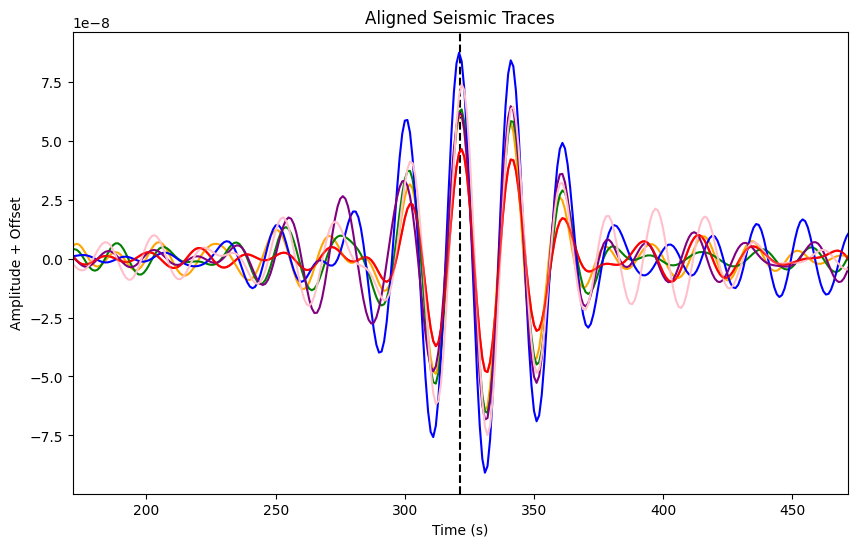

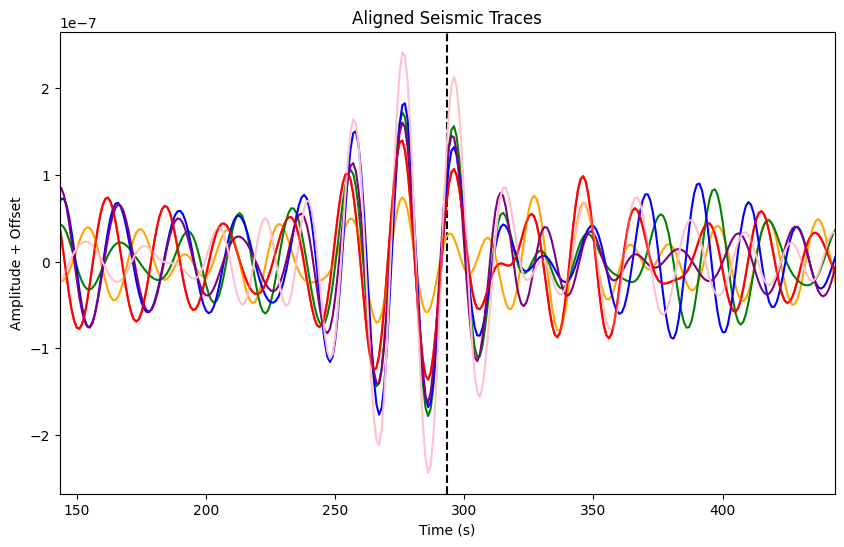

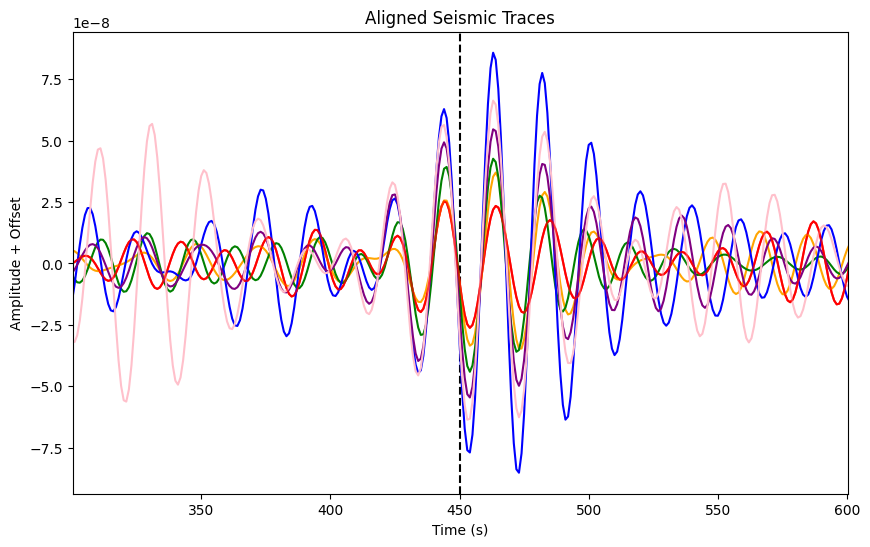

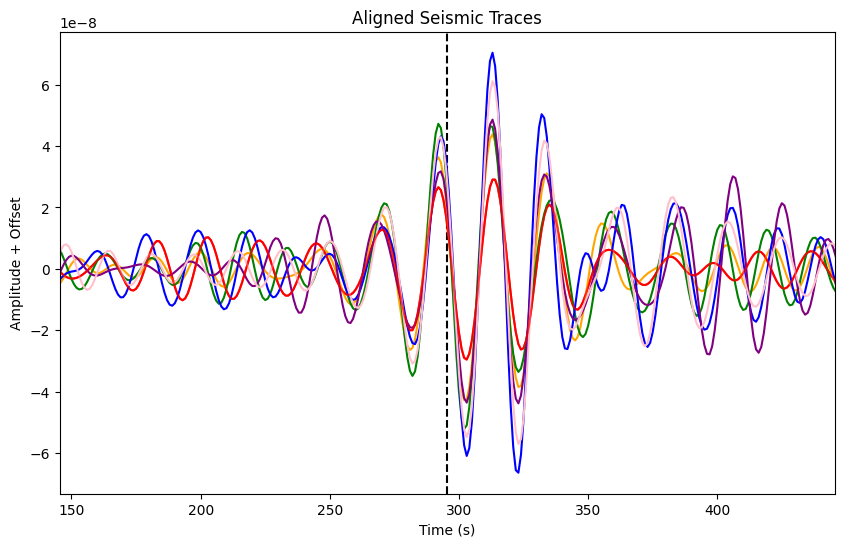

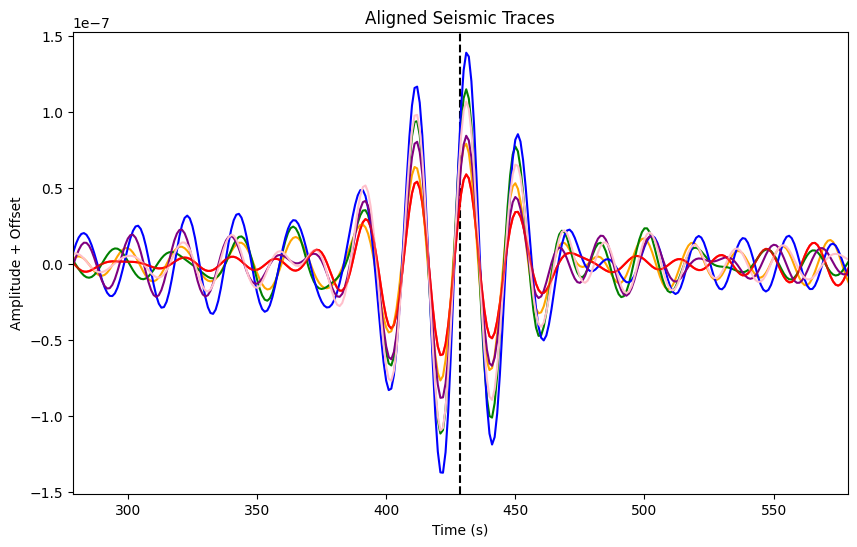

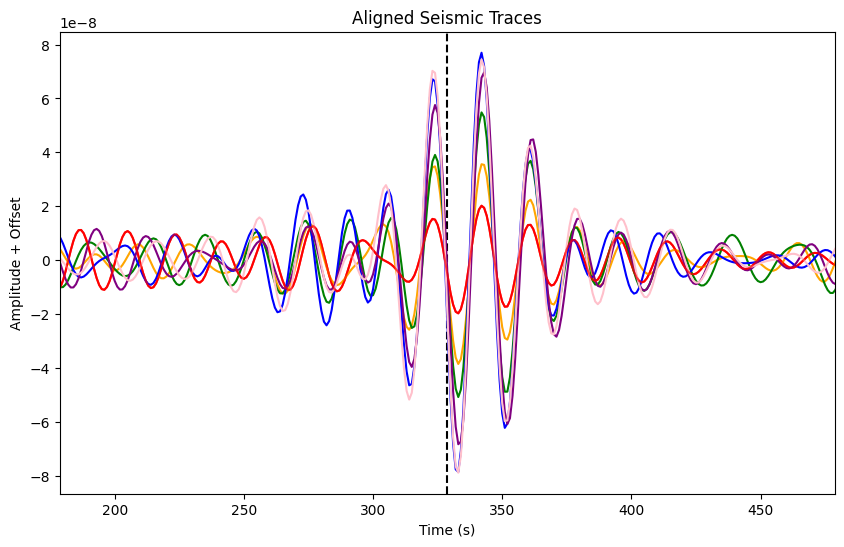

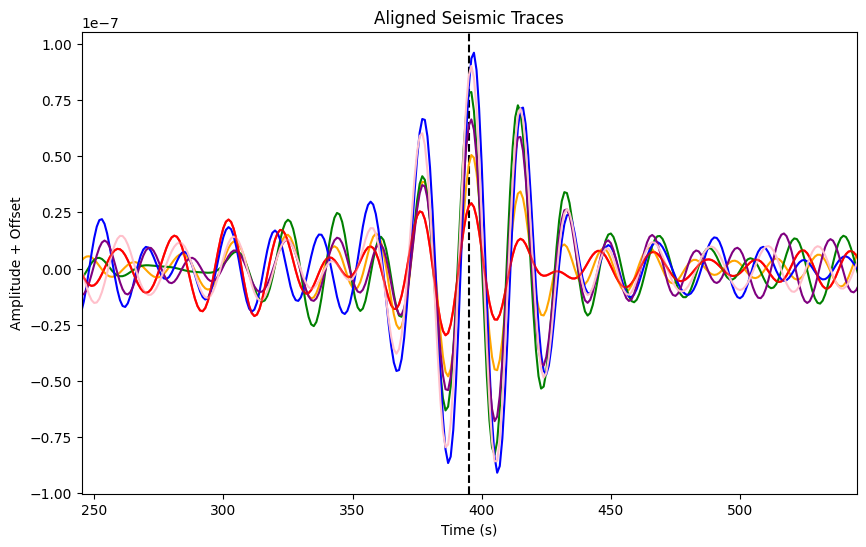

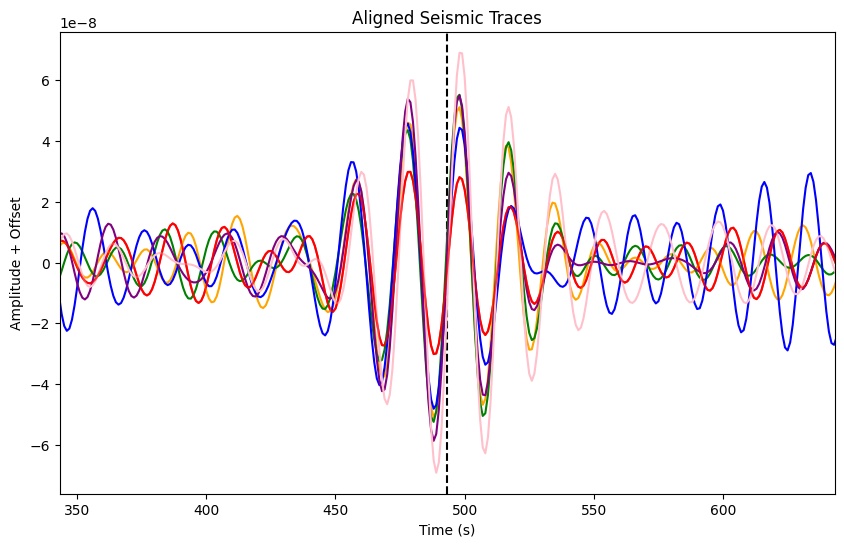

In [10]:
BEAR_alignment = plot_aligner(BEAR_data, [0, 6, 5, 7, 0, 2])
DNTW_alignment = plot_aligner(DNTW_data, [0, -13, 5, -11, -18, -17])
SILY_alignment = plot_aligner(SILY_data, [0, 28, 26 , 30, 23, 23])
THUR_alignment = plot_aligner(THUR_data, [0, 7, 6, 31, 24, 25])
UNGL_alignment = plot_aligner(UNGL_data, [0, 7, 6, 9, 2, 2])
UPTW_alignment = plot_aligner(UPTW_data, [0, 8, 6, 8, 2, 2])
WAIS_alignment = plot_aligner(WAIS_data, [0, 8, 5, 9, 1, 2])
WHIT_alignment = plot_aligner(WHIT_data, [0, 7, 5, 8, 1, 2])

In [11]:
espg_station_coords = [
    [-1567449.0307714911, -628557.0530906991], 
    [-1408125.7010859102, -451473.54680792254], 
    [-1136087.7322197275, -824386.4596839668],
    [-1895770.6749620517, -251623.0810593325],
    [-1104385.368988728, 144924.49616295868],
    [-1280669.7694494505, -441905.2495084451],
    [-1070613.1221562033, -427735.75399884465],
    [-771159.034045763, -197809.1890938298]
] # https://epsg.io/transform#s_srs=4326&t_srs=3031&x=-104.3867000&y=-82.6823000

station_x = [coord[0] for coord in espg_station_coords]
station_y = [coord[1] for coord in espg_station_coords]

In [12]:
# 1st event espg coords # << this will be our reference event for now

espg_event_1 = [-1617387.0039236946, -277336.7072374646]

events[0]

[-74.98, -99.73, '2013-11-09T07:24:51.000000Z', 2.08, 2013.9413242009134]

---
### Construction of $G$ matrix

Travel time forward prediction
$$
d_i = \frac{\sqrt{(x - x_i)^2 + (y - y_i)^2}}{c},
$$
where $(x_i, y_i); i = 1 \ldots N$ are the station Catersian coordinates in meters and $(x, y)$ are unknown source coordinates; $c=2950$ m/s is the constant surface wave speed.

The Jacobian matrix $G\in\mathcal{R}^{N\times2}$, defined as
$$
G = \left[
\begin{matrix}
\partial d_1 / \partial x & \partial d_1 / \partial y \\
\ldots&\ldots\\
\partial d_N / \partial x & \partial d_N / \partial y \\
\end{matrix}
\right],
$$
where
$$
\partial d_i / \partial x = \frac{1}{c} \frac{x - x_i} {\sqrt{(x - x_i)^2 + (y - y_i)^2}},
$$
and
$$
\partial d_i / \partial y = \frac{1}{c} \frac{y - y_i} {\sqrt{(x - x_i)^2 + (y - y_i)^2}}.
$$

In [13]:
c = 2950  # assumed constant velocity in m/s
def partial_x(x_s, y_s, x_ref, y_ref):
    # top_bit = (x_ref - x_s)/2950
    # bottom_bit = np.sqrt(((x_ref - x_s)**2 + (y_ref - y_s)**2)/2950)
    top_bit = (x_s - x_ref) / c
    bottom_bit = np.sqrt(((x_ref - x_s)**2 + (y_ref - y_s)**2))
    return top_bit / bottom_bit if bottom_bit != 0 else 0

def partial_y(x_s, y_s, x_ref, y_ref):
    # top_bit = (y_ref - y_s)/2950
    # bottom_bit = np.sqrt(((x_ref - x_s)**2 + (y_ref - y_s)**2)/2950)
    top_bit = (y_s - y_ref) / c
    bottom_bit = np.sqrt(((x_ref - x_s)**2 + (y_ref - y_s)**2))
    return top_bit / bottom_bit if bottom_bit != 0 else 0

def construct_G(event_coords, station_coords): # check this !!!!
    G = np.zeros((len(station_coords), 2))
    ex, ey = event_coords # reference event coords
    for i, (sx, sy) in enumerate(station_coords):
        G[i, 0] = partial_x(sx, sy, ex, ey)
        G[i, 1] = partial_y(sx, sy, ex, ey)
    return G

In [14]:
station_infos_xy = list(zip(sta_lats, sta_lons, station_x, station_y, networks_flat, stations_flat))

station_infos_xy

[(-74.5476, -111.8511, -1567449.0307714911, -628557.0530906991, 'YT', 'BEAR'),
 (-76.4512, -107.7769, -1408125.7010859102, -451473.54680792254, 'YT', 'DNTW'),
 (-77.1332, -125.966, -1136087.7322197275, -824386.4596839668, 'YT', 'SILY'),
 (-72.5301, -97.5606, -1895770.6749620517, -251623.0810593325, 'YT', 'THUR'),
 (-79.7746, -82.524, -1104385.368988728, 144924.49616295868, 'YT', 'UNGL'),
 (-77.5781, -109.0374, -1280669.7694494505, -441905.2495084451, 'YT', 'UPTW'),
 (-79.4181, -111.7779, -1070613.1221562033, -427735.75399884465, 'YT', 'WAIS'),
 (-82.6823, -104.3867, -771159.034045763, -197809.1890938298, 'YT', 'WHIT')]

---
### Verification of $G$ matrix

To verify the G matrix, we compare $\Delta \mathbf{d} := g(\mathbf{m}) - g(\mathbf{m} + \Delta \mathbf{m})$ and $G\Delta \mathbf{m}$. Indeed, they look rather comparable below !!!

In [15]:
## Test G matrix
G_test = construct_G(espg_event_1, espg_station_coords)
# print(G_test)

## Source perturbation
Delta_m = np.array([5e3, 10e3])  # Example perturbation in meters
Delta_t = G_test @ Delta_m
print("Predicted travel time changes (s):", np.round(Delta_t, 2))

## Double-check with forward calculation
Delta_t_forward = []
for _s in station_infos_xy:
    sta_x, sta_y = _s[2], _s[3]
    dist_1 = np.sqrt((espg_event_1[0] - sta_x)**2 + (espg_event_1[1] - sta_y)**2)
    time_to_event_1 = dist_1 / c
    
    perturbed_event = [espg_event_1[0] + Delta_m[0], espg_event_1[1] + Delta_m[1]]
    dist_1_perturbed = np.sqrt((perturbed_event[0] - sta_x)**2 + (perturbed_event[1] - sta_y)**2)
    time_to_event_1_perturbed = dist_1_perturbed / c

    Delta_t_forward.append(time_to_event_1 - time_to_event_1_perturbed)
print("Forward calculated travel time changes (s):", np.round(Delta_t_forward, 2))

Predicted travel time changes (s): [-3.12 -0.87 -1.43 -1.38  3.46  0.03  0.74  2.  ]
Forward calculated travel time changes (s): [-3.14 -0.94 -1.45 -1.44  3.46 -0.02  0.7   1.99]


In [16]:
# constructing delta d

# all points version - all at Bear then all at DNTW, etc. 
delta_d_all = [-6, -5, -7, 0, -2,
               13, -5, 11, 18, 17,
               -28, -26, -30, -23, -23,
               -7, -6, -31, -24, -25,
               -7, -6, -9, -2, -2,
               -8, -6, -8, -2, -2,
               -8, -5, -9, -1, -2,
               -7, -5, -8, -1, -2]

delta_d_all_mean = np.mean(delta_d_all)
delta_d_all_demeaned = [val - delta_d_all_mean for val in delta_d_all]

delta_d_event_2 = [-6, 13, -28, -7, -7, -8, -8, -7] # all event 2 values - first column of above
delta_d_event_3 = [-5, -5, -26, -6, -6, -6, -5, -5]
delta_d_event_4 = [-7, 11, -30, -31, -9, -8, -9, -8]
delta_d_event_5 = [0, 18, -23, -24, -2, -2, -1, -1]
delta_d_event_6 = [-2, 17, -23, -25, -2, -2, -2, -2]
delta_d_event_2_mean = np.mean(delta_d_event_2)
delta_d_event_3_mean = np.mean(delta_d_event_3)
delta_d_event_4_mean = np.mean(delta_d_event_4)
delta_d_event_5_mean = np.mean(delta_d_event_5)
delta_d_event_6_mean = np.mean(delta_d_event_6)
delta_d_event_2_demeaned = [val - delta_d_event_2_mean for val in delta_d_event_2]
delta_d_event_3_demeaned = [val - delta_d_event_3_mean for val in delta_d_event_3]
delta_d_event_4_demeaned = [val - delta_d_event_4_mean for val in delta_d_event_4]
delta_d_event_5_demeaned = [val - delta_d_event_5_mean for val in delta_d_event_5]
delta_d_event_6_demeaned = [val - delta_d_event_6_mean for val in delta_d_event_6]

In [17]:
# constructing the G matrices

station_coords_tot = [[station_infos_xy[0][2], station_infos_xy[0][3]], [station_infos_xy[0][2], station_infos_xy[0][3]], [station_infos_xy[0][2], station_infos_xy[0][3]],
                      [station_infos_xy[0][2], station_infos_xy[0][3]], [station_infos_xy[0][2], station_infos_xy[0][3]], 
                      [station_infos_xy[1][2], station_infos_xy[1][3]], [station_infos_xy[1][2], station_infos_xy[1][3]], [station_infos_xy[1][2], station_infos_xy[1][3]],
                      [station_infos_xy[1][2], station_infos_xy[1][3]], [station_infos_xy[1][2], station_infos_xy[1][3]], 
                      [station_infos_xy[2][2], station_infos_xy[2][3]], [station_infos_xy[2][2], station_infos_xy[2][3]], [station_infos_xy[2][2], station_infos_xy[2][3]],
                      [station_infos_xy[2][2], station_infos_xy[2][3]], [station_infos_xy[2][2], station_infos_xy[2][3]],
                      [station_infos_xy[3][2], station_infos_xy[3][3]], [station_infos_xy[3][2], station_infos_xy[3][3]], [station_infos_xy[3][2], station_infos_xy[3][3]],
                      [station_infos_xy[3][2], station_infos_xy[3][3]], [station_infos_xy[3][2], station_infos_xy[3][3]],
                      [station_infos_xy[4][2], station_infos_xy[4][3]], [station_infos_xy[4][2], station_infos_xy[4][3]], [station_infos_xy[4][2], station_infos_xy[4][3]],
                      [station_infos_xy[4][2], station_infos_xy[4][3]], [station_infos_xy[4][2], station_infos_xy[4][3]],
                      [station_infos_xy[5][2], station_infos_xy[5][3]], [station_infos_xy[5][2], station_infos_xy[5][3]], [station_infos_xy[5][2], station_infos_xy[5][3]],
                      [station_infos_xy[5][2], station_infos_xy[5][3]], [station_infos_xy[5][2], station_infos_xy[5][3]],
                      [station_infos_xy[6][2], station_infos_xy[6][3]], [station_infos_xy[6][2], station_infos_xy[6][3]], [station_infos_xy[6][2], station_infos_xy[6][3]],
                      [station_infos_xy[6][2], station_infos_xy[6][3]], [station_infos_xy[6][2], station_infos_xy[6][3]],
                      [station_infos_xy[7][2], station_infos_xy[7][3]], [station_infos_xy[7][2], station_infos_xy[7][3]], [station_infos_xy[7][2], station_infos_xy[7][3]],
                      [station_infos_xy[7][2], station_infos_xy[7][3]], [station_infos_xy[7][2], station_infos_xy[7][3]]]


G_tot = construct_G(espg_event_1, station_coords_tot)

G_event_specific = construct_G(espg_event_1, espg_station_coords)


In [18]:
# the optimisation stuff

delta_m_all, delta_m_all_residuals, delta_m_all_rank, delta_m_all_s = np.linalg.lstsq(G_tot, delta_d_all_demeaned, rcond=None)

print(delta_m_all)
print(delta_m_all_residuals)
print(delta_m_all_rank)
print(delta_m_all_s)

[12821.44226844  4435.40596837]
[4830.62599918]
2
[0.00183693 0.00110547]


In [19]:
delta_m_event_2, delta_m_event_2_residuals, delta_m_event_2_rank, delta_m_event_2_s = np.linalg.lstsq(G_event_specific, delta_d_event_2_demeaned, rcond=None)
delta_m_event_3, delta_m_event_3_residuals, delta_m_event_3_rank, delta_m_event_3_s = np.linalg.lstsq(G_event_specific, delta_d_event_3_demeaned, rcond=None)
delta_m_event_4, delta_m_event_4_residuals, delta_m_event_4_rank, delta_m_event_4_s = np.linalg.lstsq(G_event_specific, delta_d_event_4_demeaned, rcond=None)
delta_m_event_5, delta_m_event_5_residuals, delta_m_event_5_rank, delta_m_event_5_s = np.linalg.lstsq(G_event_specific, delta_d_event_5_demeaned, rcond=None)
delta_m_event_6, delta_m_event_6_residuals, delta_m_event_6_rank, delta_m_event_6_s = np.linalg.lstsq(G_event_specific, delta_d_event_6_demeaned, rcond=None)

print(f'Event 2 results: {delta_m_event_2}, Residuals: {delta_m_event_2_residuals}, Rank: {delta_m_event_2_rank}, S: {delta_m_event_2_s}')
print(f'Event 3 results: {delta_m_event_3}, Residuals: {delta_m_event_3_residuals}, Rank: {delta_m_event_3_rank}, S: {delta_m_event_3_s}')
print(f'Event 4 results: {delta_m_event_4}, Residuals: {delta_m_event_4_residuals}, Rank: {delta_m_event_4_rank}, S: {delta_m_event_4_s}')
print(f'Event 5 results: {delta_m_event_5}, Residuals: {delta_m_event_5_residuals}, Rank: {delta_m_event_5_rank}, S: {delta_m_event_5_s}')
print(f'Event 6 results: {delta_m_event_6}, Residuals: {delta_m_event_6_residuals}, Rank: {delta_m_event_6_rank}, S: {delta_m_event_6_s}')

Event 2 results: [1161.52199645 2939.42160688], Residuals: [841.05847983], Rank: 2, S: [0.0008215  0.00049438]
Event 3 results: [ 1432.38018759 10414.91378856], Residuals: [342.26952079], Rank: 2, S: [0.0008215  0.00049438]
Event 4 results: [20104.15622857  2242.73643138], Residuals: [1048.59968421], Rank: 2, S: [0.0008215  0.00049438]
Event 5 results: [20197.8736315   2482.90819633], Residuals: [1047.42282581], Rank: 2, S: [0.0008215  0.00049438]
Event 6 results: [21211.27929811  4097.04981867], Residuals: [996.19831042], Rank: 2, S: [0.0008215  0.00049438]


In [20]:
# constructing delta D without DNTW, SILY, and THUR

# constructing delta d

# all points version - all at Bear then all at DNTW, etc. 
delta_d_all_mod = [-6, -5, -7, 0, -2,
               -7, -6, -9, -2, -2,
               -8, -6, -8, -2, -2,
               -8, -5, -9, -1, -2,
               -7, -5, -8, -1, -2]

delta_d_all_mean_mod = np.mean(delta_d_all_mod)
delta_d_all_demeaned_mod = [val - delta_d_all_mean_mod for val in delta_d_all_mod]

delta_d_event_2_mod = [-6, -7, -8, -8, -7]
delta_d_event_3_mod = [-5, -6, -6, -5, -5]
delta_d_event_4_mod = [-7, -9, -8, -9, -8]
delta_d_event_5_mod = [ 0, -2, -2, -1, -1]
delta_d_event_6_mod = [-2, -2, -2, -2, -2]
delta_d_event_2_mean_mod = np.mean(delta_d_event_2_mod)
delta_d_event_3_mean_mod = np.mean(delta_d_event_3_mod)
delta_d_event_4_mean_mod = np.mean(delta_d_event_4_mod)
delta_d_event_5_mean_mod = np.mean(delta_d_event_5_mod)
delta_d_event_6_mean_mod = np.mean(delta_d_event_6_mod)
delta_d_event_2_demeaned_mod = [val - delta_d_event_2_mean_mod for val in delta_d_event_2_mod]
delta_d_event_3_demeaned_mod = [val - delta_d_event_3_mean_mod for val in delta_d_event_3_mod]
delta_d_event_4_demeaned_mod = [val - delta_d_event_4_mean_mod for val in delta_d_event_4_mod]
delta_d_event_5_demeaned_mod = [val - delta_d_event_5_mean_mod for val in delta_d_event_5_mod]
delta_d_event_6_demeaned_mod = [val - delta_d_event_6_mean_mod for val in delta_d_event_6_mod]

In [21]:
# constructing the G matrices without DNTW, SILY, and THUR

station_coords_tot_mod = [[station_infos_xy[0][2], station_infos_xy[0][3]], [station_infos_xy[0][2], station_infos_xy[0][3]], [station_infos_xy[0][2], station_infos_xy[0][3]],
                      [station_infos_xy[0][2], station_infos_xy[0][3]], [station_infos_xy[0][2], station_infos_xy[0][3]], 
                      [station_infos_xy[4][2], station_infos_xy[4][3]], [station_infos_xy[4][2], station_infos_xy[4][3]], [station_infos_xy[4][2], station_infos_xy[4][3]],
                      [station_infos_xy[4][2], station_infos_xy[4][3]], [station_infos_xy[4][2], station_infos_xy[4][3]],
                      [station_infos_xy[5][2], station_infos_xy[5][3]], [station_infos_xy[5][2], station_infos_xy[5][3]], [station_infos_xy[5][2], station_infos_xy[5][3]],
                      [station_infos_xy[5][2], station_infos_xy[5][3]], [station_infos_xy[5][2], station_infos_xy[5][3]],
                      [station_infos_xy[6][2], station_infos_xy[6][3]], [station_infos_xy[6][2], station_infos_xy[6][3]], [station_infos_xy[6][2], station_infos_xy[6][3]],
                      [station_infos_xy[6][2], station_infos_xy[6][3]], [station_infos_xy[6][2], station_infos_xy[6][3]],
                      [station_infos_xy[7][2], station_infos_xy[7][3]], [station_infos_xy[7][2], station_infos_xy[7][3]], [station_infos_xy[7][2], station_infos_xy[7][3]],
                      [station_infos_xy[7][2], station_infos_xy[7][3]], [station_infos_xy[7][2], station_infos_xy[7][3]]]

espg_station_coords_mod = [[-1567449.0307714911, -628557.0530906991],
                           [-1104385.368988728, 144924.49616295868],
                           [-1280669.7694494505, -441905.2495084451],
                           [-1070613.1221562033, -427735.75399884465],
                           [-771159.034045763, -197809.1890938298]]

G_tot_mod = construct_G(espg_event_1, station_coords_tot_mod)

G_event_specific_mod = construct_G(espg_event_1, espg_station_coords_mod)

In [22]:
# the optimisation stuff

delta_m_all_mod, delta_m_all_residuals_mod, delta_m_all_rank_mod, delta_m_all_s_mod = np.linalg.lstsq(G_tot_mod, delta_d_all_demeaned_mod, rcond=None)

print(delta_m_all_mod)
print(delta_m_all_residuals_mod)
print(delta_m_all_rank_mod)
print(delta_m_all_s_mod)

[ -576.55624517 -1494.72026972]
[199.43939973]
2
[0.00139122 0.00096811]


In [23]:
delta_m_event_2_mod, delta_m_event_2_residuals_mod, delta_m_event_2_rank_mod, delta_m_event_2_s_mod = np.linalg.lstsq(G_event_specific_mod, delta_d_event_2_demeaned_mod, rcond=None)
delta_m_event_3_mod, delta_m_event_3_residuals_mod, delta_m_event_3_rank_mod, delta_m_event_3_s_mod = np.linalg.lstsq(G_event_specific_mod, delta_d_event_3_demeaned_mod, rcond=None)
delta_m_event_4_mod, delta_m_event_4_residuals_mod, delta_m_event_4_rank_mod, delta_m_event_4_s_mod = np.linalg.lstsq(G_event_specific_mod, delta_d_event_4_demeaned_mod, rcond=None)
delta_m_event_5_mod, delta_m_event_5_residuals_mod, delta_m_event_5_rank_mod, delta_m_event_5_s_mod = np.linalg.lstsq(G_event_specific_mod, delta_d_event_5_demeaned_mod, rcond=None)
delta_m_event_6_mod, delta_m_event_6_residuals_mod, delta_m_event_6_rank_mod, delta_m_event_6_s_mod = np.linalg.lstsq(G_event_specific_mod, delta_d_event_6_demeaned_mod, rcond=None)

print(f'Event 2 results: {delta_m_event_2_mod}, Residuals: {delta_m_event_2_residuals_mod}, Rank: {delta_m_event_2_rank_mod}, S: {delta_m_event_2_s_mod}')
print(f'Event 3 results: {delta_m_event_3_mod}, Residuals: {delta_m_event_3_residuals_mod}, Rank: {delta_m_event_3_rank_mod}, S: {delta_m_event_3_s_mod}')
print(f'Event 4 results: {delta_m_event_4_mod}, Residuals: {delta_m_event_4_residuals_mod}, Rank: {delta_m_event_4_rank_mod}, S: {delta_m_event_4_s_mod}')
print(f'Event 5 results: {delta_m_event_5_mod}, Residuals: {delta_m_event_5_residuals_mod}, Rank: {delta_m_event_5_rank_mod}, S: {delta_m_event_5_s_mod}')
print(f'Event 6 results: {delta_m_event_6_mod}, Residuals: {delta_m_event_6_residuals_mod}, Rank: {delta_m_event_6_rank_mod}, S: {delta_m_event_6_s_mod}')

Event 2 results: [-913.08306251 -966.36161798], Residuals: [2.34365902], Rank: 2, S: [0.00062217 0.00043295]
Event 3 results: [ -208.43246254 -1063.62414494], Residuals: [0.97851831], Rank: 2, S: [0.00062217 0.00043295]
Event 4 results: [ -919.46285445 -2881.5181205 ], Residuals: [1.02044564], Rank: 2, S: [0.00062217 0.00043295]
Event 5 results: [ -841.80284638 -2562.09746518], Residuals: [1.3805796], Rank: 2, S: [0.00062217 0.00043295]
Event 6 results: [0. 0.], Residuals: [0.], Rank: 2, S: [0.00062217 0.00043295]


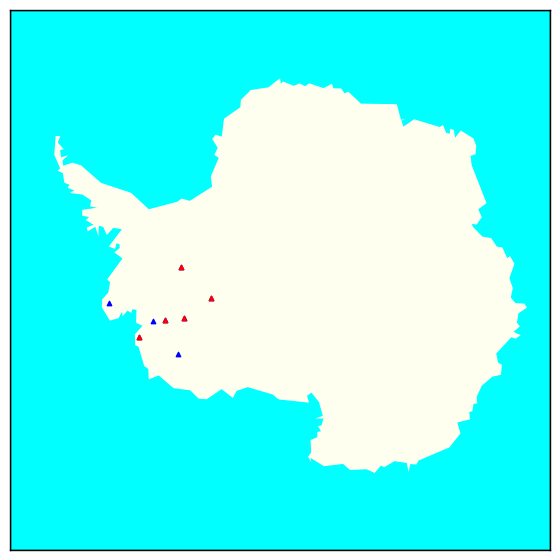

In [24]:
# plotting the stations mod

sta_lats_mod = [sta_lats[0], sta_lats[4], sta_lats[5], sta_lats[6], sta_lats[7]]
sta_lons_mod = [sta_lons[0], sta_lons[4], sta_lons[5], sta_lons[6], sta_lons[7]]

fig = plt.figure(figsize=(9, 6))
xa = fig.add_axes([0.90, 0.90, 0.90, 0.90])

ma = Basemap(epsg='3031', width=6e6, height=6e6, ax=xa)
wa, ha = ma.xmax, ma.ymax

ma.drawmapboundary(fill_color='aqua')
ma.fillcontinents(color='ivory', lake_color='aqua')
son1 = ma.scatter(sta_lons, sta_lats, s=10, marker='^', latlon=True, color='b')
son2 = ma.scatter(sta_lons_mod, sta_lats_mod, s=10, marker='^', latlon=True, color='r')

plt.show()

In [25]:
station_infos_xy

[(-74.5476, -111.8511, -1567449.0307714911, -628557.0530906991, 'YT', 'BEAR'),
 (-76.4512, -107.7769, -1408125.7010859102, -451473.54680792254, 'YT', 'DNTW'),
 (-77.1332, -125.966, -1136087.7322197275, -824386.4596839668, 'YT', 'SILY'),
 (-72.5301, -97.5606, -1895770.6749620517, -251623.0810593325, 'YT', 'THUR'),
 (-79.7746, -82.524, -1104385.368988728, 144924.49616295868, 'YT', 'UNGL'),
 (-77.5781, -109.0374, -1280669.7694494505, -441905.2495084451, 'YT', 'UPTW'),
 (-79.4181, -111.7779, -1070613.1221562033, -427735.75399884465, 'YT', 'WAIS'),
 (-82.6823, -104.3867, -771159.034045763, -197809.1890938298, 'YT', 'WHIT')]

In [26]:
events

[[-74.98, -99.73, '2013-11-09T07:24:51.000000Z', 2.08, 2013.9413242009134],
 [-75.0, -99.84, '2013-11-10T19:16:40.000000Z', 2.17, 2013.9440639269408],
 [-74.95, -99.81, '2013-11-15T13:24:15.000000Z', 2.27, 2013.9577625570778],
 [-75.12, -99.65, '2013-11-19T12:46:17.000000Z', 2.43, 2013.9687214611872],
 [-74.92, -99.43, '2013-11-21T07:28:51.000000Z', 2.14, 2013.9742009132422],
 [-74.97, -99.46, '2013-11-23T04:22:04.000000Z', 2.27, 2013.9796803652969]]

In [27]:
import rasterio
from pyproj import Proj
import numpy as np

with rasterio.open(r"C:\Users\thele\Dropbox\PC\Desktop\Honours\python\Mapping\moa125_2014_hp1_v01.tif") as raster:
    img_data = raster.read(1)  # Read the first band (assuming it's a single band image)
    img_x = np.linspace(raster.bounds.left, raster.bounds.right, raster.width)
    img_y = np.linspace(raster.bounds.top, raster.bounds.bottom, raster.height)
    stere_proj = Proj('+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
    #proj = Proj(raster.crs)
    #img_lon, img_lat = stere_proj(*np.meshgrid(img_x, img_y), inverse=True)

In [28]:
espg_event_1

[-1617387.0039236946, -277336.7072374646]

In [29]:
delta_m_event_2

array([1161.52199645, 2939.42160688])

In [30]:
espg_event_2_v1 = espg_event_1 + delta_m_event_2
loc_event_2_v1 = stere_proj(espg_event_2_v1[0], espg_event_2_v1[1], inverse=True)
espg_event_3_v1 = espg_event_1 + delta_m_event_3
loc_event_3_v1 = stere_proj(espg_event_3_v1[0], espg_event_3_v1[1], inverse=True)
espg_event_4_v1 = espg_event_1 + delta_m_event_4
loc_event_4_v1 = stere_proj(espg_event_4_v1[0], espg_event_4_v1[1], inverse=True)
espg_event_5_v1 = espg_event_1 + delta_m_event_5
loc_event_5_v1 = stere_proj(espg_event_5_v1[0], espg_event_5_v1[1], inverse=True)
espg_event_6_v1 = espg_event_1 + delta_m_event_6
loc_event_6_v1 = stere_proj(espg_event_6_v1[0], espg_event_6_v1[1], inverse=True)
espg_event_2_v2 = espg_event_1 + delta_m_event_2_mod
loc_event_2_v2 = stere_proj(espg_event_2_v2[0], espg_event_2_v2[1], inverse=True)
espg_event_3_v2 = espg_event_1 + delta_m_event_3_mod
loc_event_3_v2 = stere_proj(espg_event_3_v2[0], espg_event_3_v2[1], inverse=True)
espg_event_4_v2 = espg_event_1 + delta_m_event_4_mod
loc_event_4_v2 = stere_proj(espg_event_4_v2[0], espg_event_4_v2[1], inverse=True)
espg_event_5_v2 = espg_event_1 + delta_m_event_5_mod
loc_event_5_v2 = stere_proj(espg_event_5_v2[0], espg_event_5_v2[1], inverse=True)
espg_event_6_v2 = espg_event_1 + delta_m_event_6_mod
loc_event_6_v2 = stere_proj(espg_event_6_v2[0], espg_event_6_v2[1], inverse=True)

loc_events_v1 = [stere_proj(espg_event_1[0], espg_event_1[1], inverse=True), loc_event_2_v1, loc_event_3_v1, loc_event_4_v1, loc_event_5_v1, loc_event_6_v1]
espg_events_v1 = [espg_event_1, espg_event_2_v1, espg_event_3_v1, espg_event_4_v1, espg_event_5_v1, espg_event_6_v1]
loc_events_v2 = [stere_proj(espg_event_1[0], espg_event_1[1], inverse=True), loc_event_2_v2, loc_event_3_v2, loc_event_4_v2, loc_event_5_v2, loc_event_6_v2]
espg_events_v2 = [espg_event_1, espg_event_2_v2, espg_event_3_v2, espg_event_4_v2, espg_event_5_v2, espg_event_6_v2]

In [31]:
loc_events_v1

[(-99.73, -74.97999999999999),
 (-99.63560514270561, -74.99484080738706),
 (-99.37936978696331, -75.0084377381185),
 (-99.77196924080269, -75.16284138784553),
 (-99.76416392832316, -75.1640468346507),
 (-99.71396207511458, -75.1755652217523)]

In [32]:
events

[[-74.98, -99.73, '2013-11-09T07:24:51.000000Z', 2.08, 2013.9413242009134],
 [-75.0, -99.84, '2013-11-10T19:16:40.000000Z', 2.17, 2013.9440639269408],
 [-74.95, -99.81, '2013-11-15T13:24:15.000000Z', 2.27, 2013.9577625570778],
 [-75.12, -99.65, '2013-11-19T12:46:17.000000Z', 2.43, 2013.9687214611872],
 [-74.92, -99.43, '2013-11-21T07:28:51.000000Z', 2.14, 2013.9742009132422],
 [-74.97, -99.46, '2013-11-23T04:22:04.000000Z', 2.27, 2013.9796803652969]]

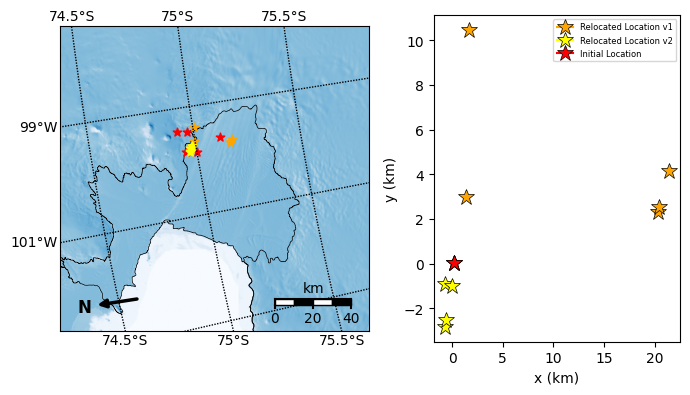

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig, ax = plt.subplots(1, 2, figsize=(7, 4), gridspec_kw={'width_ratios': [1, 0.8]})
m = Basemap(epsg=3031, llcrnrlon=-102.5, llcrnrlat=-74.2, urcrnrlon=-98, urcrnrlat=-75.9, ax=ax[0])
min_x, min_y = stere_proj(m.llcrnrlon, m.llcrnrlat)
max_x, max_y = stere_proj(m.urcrnrlon, m.urcrnrlat)
mask_x = (min_x <= img_x) & (img_x <= max_x)
mask_y = (min_y <= img_y) & (img_y <= max_y)

m.readshapefile('Groundinglines/moa2014_grounding_line_v01_wgs84', 'grounding', linewidth=0.5, color='k', zorder=1)
m.readshapefile('Coastlines/moa2014_coastline_v01_wgs84', 'coastline', linewidth=0.5, color='k', zorder=1)
#m.readshapefile('METADATA/MOAAntarctica/moa2014_islands_v01_wgs84', 'islands', linewidth=0.5, color='k', zorder=1)
# m.pcolormesh(img_lon[mask_y, :][:, mask_x], img_lat[mask_y, :][:, mask_x], 
#              img_data[mask_y, :][:, mask_x], shading='auto', latlon=True, zorder=0, cmap='Blues')
# background topographic image
tmp = img_data[np.logical_and(min_y<=img_y, img_y<=max_y)][:, np.logical_and(min_x<=img_x, img_x<=max_x)]
m.imshow(tmp, cmap='Blues', origin='upper')


m.drawparallels(np.arange(-80, -70, .5), labels=[0, 0, 1, 1])
m.drawmeridians(np.arange(-105, -95, 2), labels=[1, 0, 0, 0])
m.ax.annotate('N', xy=m(-102.25, -74.6), xytext=m(-102.25, -74.3), fontsize=12, fontweight='bold',
              arrowprops=dict(arrowstyle='<|-', linewidth=2.5, color='k'))
m.drawmapscale(-103, -75.4, -101, -75, 40, barstyle='fancy', zorder=2, units='km', fontsize=10)

# initial events
for event in events:
    m.scatter(event[1], event[0], c='r', s=40, marker='*', latlon=True)

# relocated events v1
for event in loc_events_v1:
    m.scatter(event[0], event[1], c='orange', s=40, marker='*', latlon=True)
    # m.scatter(event[0], event[1], c='orange', s=10, latlon=True)

# relocated events v2
for event in loc_events_v2:
    m.scatter(event[0], event[1], c='yellow', s=40, marker='*', latlon=True)

# for i in range(len(espg_events_v1)):
#     ax[1].plot(espg_events_v1[i][0], espg_events_v1[i][1], c='r', ms=12, marker='*', mec='k', mew=0.5)
#     ax[1].plot(espg_events_v2[i][0], espg_events_v2[i][1], c='orange', ms=12, marker='*', mec='k', mew=0.5)

for i in range(len(espg_events_v2)):
    x, y = np.array(m(loc_events_v1[i][0], loc_events_v1[i][1])) / 1e3 - (68.7, 96.45)
    ax[1].plot(x, y, c='orange', ms=12, marker='*', mec='k', mew=0.5, label='Relocated Location v1' if i==1 else "")
    
    x, y = np.array(m(loc_events_v2[i][0], loc_events_v2[i][1])) / 1e3 - (68.7, 96.45)
    ax[1].plot(x, y, c='yellow', ms=12, marker='*', mec='k', mew=0.5, label='Relocated Location v2' if i==1 else "")
    
x0, y0 = np.array(m(loc_events_v1[0][0], loc_events_v1[0][1])) / 1e3 - (68.7, 96.45)
ax[1].plot(x0, y0, c='r', ms=12, marker='*', mec='k', mew=0.5, label='Initial Location')

ax[1].set(xlabel='x (km)', ylabel='y (km)')
ax[1].legend(loc='upper right', fontsize=6)

fig.tight_layout()
plt.show()

In [34]:
# BEAR_alignment = plot_aligner(BEAR_data, [0, 6, 5, 7, 0, 2])
# DNTW_alignment = plot_aligner(DNTW_data, [0, -13, 5, -11, -18, -17])
# SILY_alignment = plot_aligner(SILY_data, [0, 28, 26 , 30, 23, 23])
# THUR_alignment = plot_aligner(THUR_data, [0, 7, 6, 31, 24, 25])
# UNGL_alignment = plot_aligner(UNGL_data, [0, 7, 6, 9, 2, 2])
# UPTW_alignment = plot_aligner(UPTW_data, [0, 8, 6, 8, 2, 2])
# WAIS_alignment = plot_aligner(WAIS_data, [0, 8, 5, 9, 1, 2])
# WHIT_alignment = plot_aligner(WHIT_data, [0, 7, 5, 8, 1, 2])

def plot_aligner(station, tshifts):
    fig, ax = plt.subplots(figsize=(10, 6))
    colours = ['red', 'orange', 'green', 'blue', 'purple', 'pink']

    traces, arrival_times = station[0], station[2]
    
    ax.axvline(arrival_times[0], color='k', linestyle='--', label='Event Time (0)')

    for i, trace in enumerate(traces):
        ax.plot(trace.times() + tshifts[i], trace.data, color=colours[i % len(colours)])  # scale for visibility
        #ax.text(tshifts[i] - 50, i * 1e3, trace.stats.station, fontsize=8, verticalalignment='center')
    ax.plot(traces[3].times(), traces[3].data, color='blue', label='event 4', alpha=0.9)
    ax.set_xlabel('Time (s)')
    ax.set_xlim(arrival_times[0]-150, arrival_times[0]+150)
    ax.set_ylabel('Amplitude + Offset')
    ax.set_title('Aligned Seismic Traces')
    plt.show()
    return fig, ax

In [35]:
# BEAR_alignment2 = plot_aligner(BEAR_data, [-6, 0, -1, 2, -6, -5])
# DNTW_alignment2 = plot_aligner(DNTW_data, [14, 0, -1, 2, -4, -4])
# SILY_alignment2 = plot_aligner(SILY_data, [-8, 0, -1 , 3, -4, -4])
# THUR_alignment2 = plot_aligner(THUR_data, [-7, 0, -1, 24, -3, -3])
# UNGL_alignment2 = plot_aligner(UNGL_data, [-7, 0, -1, 2, -5, -5])
# UPTW_alignment2 = plot_aligner(UPTW_data, [-7, 0, -2, 0, -7, -6])
# WAIS_alignment2 = plot_aligner(WAIS_data, [-7, 0, -3, 0, -7, -6])
# WHIT_alignment2 = plot_aligner(WHIT_data, [-7, 0, -2, 1, -6, -5])

# BEAR_alignment3 = plot_aligner(BEAR_data, [-8, -1, -3, 0, -7, -6])
# DNTW_alignment3 = plot_aligner(DNTW_data, [12, -1, -2, 0, -6, -6])
# SILY_alignment3 = plot_aligner(SILY_data, [-11, -3 , -4, 0, -7, -7])
# THUR_alignment3 = plot_aligner(THUR_data, [-11, -3, -4, 0, -7, -6])
# UNGL_alignment3 = plot_aligner(UNGL_data, [-9, -1, -3, 0, -7, -7])
# UPTW_alignment3 = plot_aligner(UPTW_data, [-9, -1, -3, 0, -7, -6])
# WAIS_alignment3 = plot_aligner(WAIS_data, [-8, 0, -3, 0, -7, -6])
# WHIT_alignment3 = plot_aligner(WHIT_data, [-8, -1, -3, 0, -7, -7])

In [36]:
espg_event_2 = stere_proj(events[1][1], events[1][0], inverse=False)
espg_event_4 = stere_proj(events[3][1], events[3][0], inverse=False)

espg_event_2, espg_event_4

((-1614674.819115481, -280063.79808696726),
 (-1602528.7044816094, -272486.1314301958))

In [37]:
delta_d2_event_1 = [6, -14, 8, 7, 7, 7, 7, 7]
delta_d2_event_3 = [1, 1, 1, 1, 1, 2, 3, 2]
delta_d2_event_4 = [-2, -2, -3, -24, -2, 0, 0, -1]
delta_d2_event_5 = [6, 4, 4, 3, 5, 7, 7, 6]
delta_d2_event_6 = [5, 4, 4, 3, 5, 6, 6, 5]

delta_d4_event_1 = [8, -12, 11, 1, 9, 9, 8, 8]
delta_d4_event_2 = [1, 1, 3, 3, 1, 1, 0, 1]
delta_d4_event_3 = [3, 2, 4, 4, 3, 3, 3, 3]
delta_d4_event_5 = [7, 6, 7, 7, 7, 7, 7, 7]
delta_d4_event_6 = [6, 6, 7, 6, 7, 6, 6, 7]

delta_d2_event_1_mean = np.mean(delta_d2_event_1)
delta_d2_event_3_mean = np.mean(delta_d2_event_3)
delta_d2_event_4_mean = np.mean(delta_d2_event_4)
delta_d2_event_5_mean = np.mean(delta_d2_event_5)
delta_d2_event_6_mean = np.mean(delta_d2_event_6)
delta_d2_event_1_demeaned = [val - delta_d2_event_1_mean for val in delta_d2_event_1]
delta_d2_event_3_demeaned = [val - delta_d2_event_3_mean for val in delta_d2_event_3]
delta_d2_event_4_demeaned = [val - delta_d2_event_4_mean for val in delta_d2_event_4]
delta_d2_event_5_demeaned = [val - delta_d2_event_5_mean for val in delta_d2_event_5]
delta_d2_event_6_demeaned = [val - delta_d2_event_6_mean for val in delta_d2_event_6]

delta_d4_event_1_mean = np.mean(delta_d4_event_1)
delta_d4_event_2_mean = np.mean(delta_d4_event_2)
delta_d4_event_3_mean = np.mean(delta_d4_event_3)
delta_d4_event_5_mean = np.mean(delta_d4_event_5)
delta_d4_event_6_mean = np.mean(delta_d4_event_6)
delta_d4_event_1_demeaned = [val - delta_d4_event_1_mean for val in delta_d4_event_1]
delta_d4_event_2_demeaned = [val - delta_d4_event_2_mean for val in delta_d4_event_2]
delta_d4_event_3_demeaned = [val - delta_d4_event_3_mean for val in delta_d4_event_3]
delta_d4_event_5_demeaned = [val - delta_d4_event_5_mean for val in delta_d4_event_5]
delta_d4_event_6_demeaned = [val - delta_d4_event_6_mean for val in delta_d4_event_6]

In [38]:
G_event_specific2 = construct_G(espg_event_2, espg_station_coords)
G_event_specific4 = construct_G(espg_event_4, espg_station_coords)

In [39]:
delta_m2_event_1, delta_m2_event_1_residuals, delta_m2_event_1_rank, delta_m2_event_1_s = np.linalg.lstsq(G_event_specific2, delta_d2_event_1_demeaned, rcond=None)
delta_m2_event_3, delta_m2_event_3_residuals, delta_m2_event_3_rank, delta_m2_event_3_s = np.linalg.lstsq(G_event_specific2, delta_d2_event_3_demeaned, rcond=None)
delta_m2_event_4, delta_m2_event_4_residuals, delta_m2_event_4_rank, delta_m2_event_4_s = np.linalg.lstsq(G_event_specific2, delta_d2_event_4_demeaned, rcond=None)
delta_m2_event_5, delta_m2_event_5_residuals, delta_m2_event_5_rank, delta_m2_event_5_s = np.linalg.lstsq(G_event_specific2, delta_d2_event_5_demeaned, rcond=None)
delta_m2_event_6, delta_m2_event_6_residuals, delta_m2_event_6_rank, delta_m2_event_6_s = np.linalg.lstsq(G_event_specific2, delta_d2_event_6_demeaned, rcond=None)

print(f'Event 1 results: {delta_m2_event_1}, Residuals: {delta_m2_event_1_residuals}, Rank: {delta_m2_event_1_rank}, S: {delta_m2_event_1_s}')
print(f'Event 3 results: {delta_m2_event_3}, Residuals: {delta_m2_event_3_residuals}, Rank: {delta_m2_event_3_rank}, S: {delta_m2_event_3_s}')
print(f'Event 4 results: {delta_m2_event_4}, Residuals: {delta_m2_event_4_residuals}, Rank: {delta_m2_event_4_rank}, S: {delta_m2_event_4_s}')
print(f'Event 5 results: {delta_m2_event_5}, Residuals: {delta_m2_event_5_residuals}, Rank: {delta_m2_event_5_rank}, S: {delta_m2_event_5_s}')
print(f'Event 6 results: {delta_m2_event_6}, Residuals: {delta_m2_event_6_residuals}, Rank: {delta_m2_event_6_rank}, S: {delta_m2_event_6_s}')

Event 1 results: [-533.95398901 8417.07033779], Residuals: [364.87434068], Rank: 2, S: [0.00082092 0.00049535]
Event 3 results: [1151.8126969  844.5810327], Residuals: [3.25219402], Rank: 2, S: [0.00082092 0.00049535]
Event 4 results: [19679.25801046   800.67282413], Residuals: [219.47730212], Rank: 2, S: [0.00082092 0.00049535]
Event 5 results: [2556.51555663  631.65615737], Residuals: [11.82872087], Rank: 2, S: [0.00082092 0.00049535]
Event 6 results: [2141.05311862  957.23539839], Residuals: [5.00098142], Rank: 2, S: [0.00082092 0.00049535]


In [40]:
delta_m4_event_1, delta_m4_event_1_residuals, delta_m4_event_1_rank, delta_m4_event_1_s = np.linalg.lstsq(G_event_specific4, delta_d4_event_1_demeaned, rcond=None)
delta_m4_event_2, delta_m4_event_2_residuals, delta_m4_event_2_rank, delta_m4_event_2_s = np.linalg.lstsq(G_event_specific4, delta_d4_event_2_demeaned, rcond=None)
delta_m4_event_3, delta_m4_event_3_residuals, delta_m4_event_3_rank, delta_m4_event_3_s = np.linalg.lstsq(G_event_specific4, delta_d4_event_3_demeaned, rcond=None)
delta_m4_event_5, delta_m4_event_5_residuals, delta_m4_event_5_rank, delta_m4_event_5_s = np.linalg.lstsq(G_event_specific4, delta_d4_event_5_demeaned, rcond=None)
delta_m4_event_6, delta_m4_event_6_residuals, delta_m4_event_6_rank, delta_m4_event_6_s = np.linalg.lstsq(G_event_specific4, delta_d4_event_6_demeaned, rcond=None)

print(f'Event 1 results: {delta_m4_event_1}, Residuals: {delta_m4_event_1_residuals}, Rank: {delta_m4_event_1_rank}, S: {delta_m4_event_1_s}')
print(f'Event 3 results: {delta_m4_event_2}, Residuals: {delta_m4_event_2_residuals}, Rank: {delta_m4_event_2_rank}, S: {delta_m4_event_2_s}')
print(f'Event 4 results: {delta_m4_event_3}, Residuals: {delta_m4_event_3_residuals}, Rank: {delta_m4_event_3_rank}, S: {delta_m4_event_3_s}')
print(f'Event 5 results: {delta_m4_event_5}, Residuals: {delta_m4_event_5_residuals}, Rank: {delta_m4_event_5_rank}, S: {delta_m4_event_5_s}')
print(f'Event 6 results: {delta_m4_event_6}, Residuals: {delta_m4_event_6_residuals}, Rank: {delta_m4_event_6_rank}, S: {delta_m4_event_6_s}')

Event 1 results: [5754.26476302 7336.64836028], Residuals: [374.72618201], Rank: 2, S: [0.0008144  0.00050599]
Event 3 results: [-2081.06935076 -1180.13060073], Residuals: [5.53422817], Rank: 2, S: [0.0008144  0.00050599]
Event 4 results: [-928.37554743 -122.51511128], Residuals: [2.38356717], Rank: 2, S: [0.0008144  0.00050599]
Event 5 results: [-32.07746793 392.33000427], Residuals: [0.82203533], Rank: 2, S: [0.0008144  0.00050599]
Event 6 results: [ 800.94480773 1288.02771399], Residuals: [1.26192398], Rank: 2, S: [0.0008144  0.00050599]


In [41]:
espg_event_1_v3 = espg_event_2 + delta_m2_event_1
loc_event_1_v3 = stere_proj(espg_event_1_v3[0], espg_event_1_v3[1], inverse=True)
espg_event_3_v3 = espg_event_2 + delta_m2_event_3
loc_event_3_v3 = stere_proj(espg_event_3_v3[0], espg_event_3_v3[1], inverse=True)
espg_event_4_v3 = espg_event_2 + delta_m2_event_4
loc_event_4_v3 = stere_proj(espg_event_4_v3[0], espg_event_4_v3[1], inverse=True)
espg_event_5_v3 = espg_event_2 + delta_m2_event_5
loc_event_5_v3 = stere_proj(espg_event_5_v3[0], espg_event_5_v3[1], inverse=True)
espg_event_6_v3 = espg_event_2 + delta_m2_event_6
loc_event_6_v3 = stere_proj(espg_event_6_v3[0], espg_event_6_v3[1], inverse=True)
espg_event_1_v4 = espg_event_4 + delta_m4_event_1
loc_event_1_v4 = stere_proj(espg_event_1_v4[0], espg_event_1_v4[1], inverse=True)
espg_event_2_v4 = espg_event_4 + delta_m4_event_2
loc_event_2_v4 = stere_proj(espg_event_2_v4[0], espg_event_2_v4[1], inverse=True)
espg_event_3_v4 = espg_event_4 + delta_m4_event_3
loc_event_3_v4 = stere_proj(espg_event_3_v4[0], espg_event_3_v4[1], inverse=True)
espg_event_5_v4 = espg_event_4 + delta_m4_event_5
loc_event_5_v4 = stere_proj(espg_event_5_v4[0], espg_event_5_v4[1], inverse=True)
espg_event_6_v4 = espg_event_4 + delta_m4_event_6
loc_event_6_v4 = stere_proj(espg_event_6_v4[0], espg_event_6_v4[1], inverse=True)

loc_events_v3 = [loc_event_1_v3, stere_proj(espg_event_2[0], espg_event_2[1], inverse=True), loc_event_3_v3, loc_event_4_v3, loc_event_5_v3, loc_event_6_v3]
espg_events_v3 = [espg_event_1_v3, espg_event_2, espg_event_3_v3, espg_event_4_v3, espg_event_5_v3, espg_event_6_v3]
loc_events_v4 = [loc_event_1_v4, loc_event_2_v4, loc_event_3_v4, stere_proj(espg_event_4[0], espg_event_4[1], inverse=True), loc_event_5_v4, loc_event_6_v4]
espg_events_v4 = [espg_event_1_v4, espg_event_2_v4, espg_event_3_v4, espg_event_4, espg_event_5_v4, espg_event_6_v4]

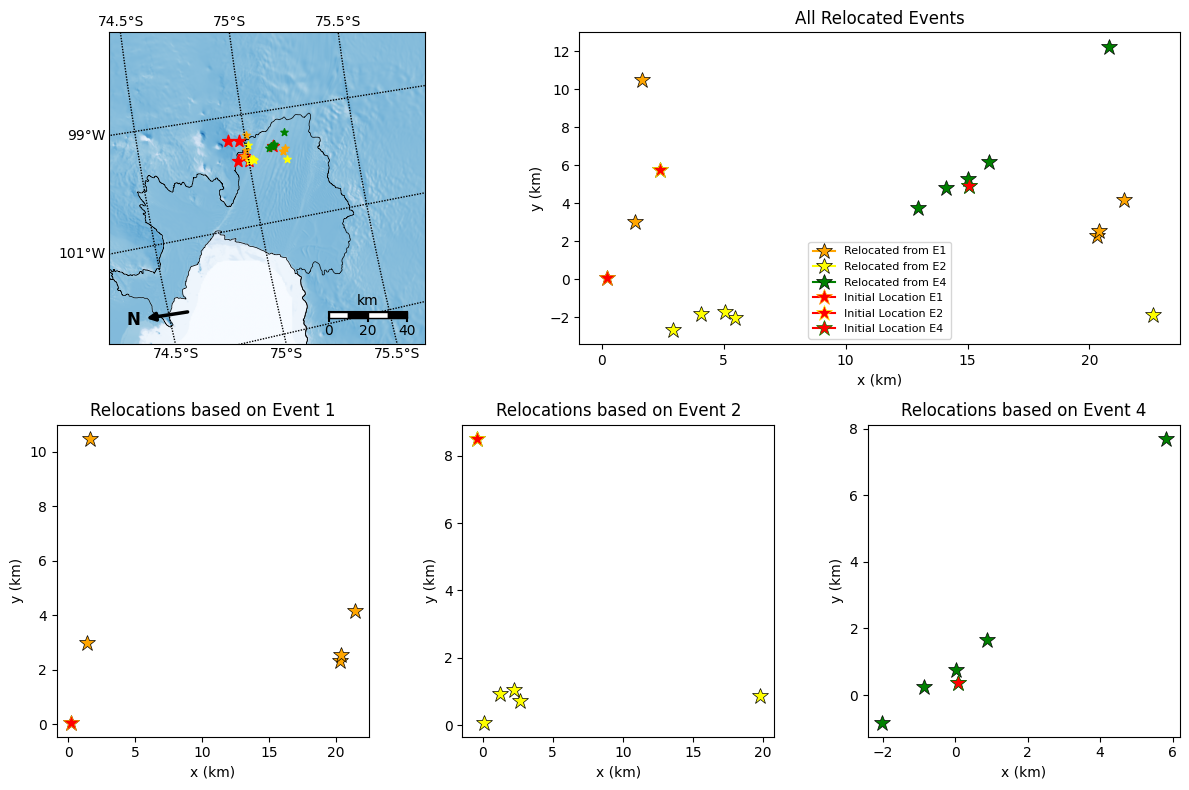

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 8))

# Create a main GridSpec with 2 rows
gs_main = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 1])

# Top row: create a nested GridSpec with width ratios 1, 0.8
gs_top = gridspec.GridSpecFromSubplotSpec(1, 2, gs_main[0], width_ratios=[0.7, 1])

# Bottom row: create a nested GridSpec with equal widths
gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, gs_main[1], wspace=0.3)

# Create subplots
ax1 = fig.add_subplot(gs_top[0, 0])   # Top left

m = Basemap(epsg=3031, llcrnrlon=-102.5, llcrnrlat=-74.2, urcrnrlon=-98, urcrnrlat=-75.9, ax=ax1)
min_x, min_y = stere_proj(m.llcrnrlon, m.llcrnrlat)
max_x, max_y = stere_proj(m.urcrnrlon, m.urcrnrlat)
mask_x = (min_x <= img_x) & (img_x <= max_x)
mask_y = (min_y <= img_y) & (img_y <= max_y)

m.readshapefile('Groundinglines/moa2014_grounding_line_v01_wgs84', 'grounding', linewidth=0.5, color='k', zorder=1)
m.readshapefile('Coastlines/moa2014_coastline_v01_wgs84', 'coastline', linewidth=0.5, color='k', zorder=1)
tmp = img_data[np.logical_and(min_y<=img_y, img_y<=max_y)][:, np.logical_and(min_x<=img_x, img_x<=max_x)]
m.imshow(tmp, cmap='Blues', origin='upper')

m.drawparallels(np.arange(-80, -70, .5), labels=[0, 0, 1, 1])
m.drawmeridians(np.arange(-105, -95, 2), labels=[1, 0, 0, 0])
m.ax.annotate('N', xy=m(-102.25, -74.6), xytext=m(-102.25, -74.3), fontsize=12, fontweight='bold',
              arrowprops=dict(arrowstyle='<|-', linewidth=2.5, color='k'))
m.drawmapscale(-103, -75.4, -101, -75, 40, barstyle='fancy', zorder=2, units='km', fontsize=10)

# initial events
for event in events:
    m.scatter(event[1], event[0], c='r', s=80, marker='*', latlon=True)

# relocated events v1
for event in loc_events_v1:
    m.scatter(event[0], event[1], c='orange', s=30, marker='*', latlon=True)

# relocated events v3
for event in loc_events_v3:
    m.scatter(event[0], event[1], c='yellow', s=30, marker='*', latlon=True)

# relocated events v4
for event in loc_events_v4:
    m.scatter(event[0], event[1], c='green', s=30, marker='*', latlon=True)

####################################################################################################################

ax2 = fig.add_subplot(gs_top[0, 1])   # Top right (narrower)

for i in range(len(espg_events_v2)):
    x, y = np.array(m(loc_events_v1[i][0], loc_events_v1[i][1])) / 1e3 - (68.7, 96.45)
    ax2.plot(x, y, c='orange', ms=12, marker='*', mec='k', mew=0.5, label='Relocated from E1' if i==1 else "")

    x, y = np.array(m(loc_events_v3[i][0], loc_events_v3[i][1])) / 1e3 - (68.7, 96.45)
    ax2.plot(x, y, c='yellow', ms=12, marker='*', mec='k', mew=0.5, label='Relocated from E2' if i==1 else "")
    
    x, y = np.array(m(loc_events_v4[i][0], loc_events_v4[i][1])) / 1e3 - (68.7, 96.45)
    ax2.plot(x, y, c='green', ms=12, marker='*', mec='k', mew=0.5, label='Relocated from E4' if i==1 else "")
    
x0, y0 = np.array(m(loc_events_v1[0][0], loc_events_v1[0][1])) / 1e3 - (68.7, 96.45)
ax2.plot(x0, y0, c='r', ms=12, marker='*', mec='orange', mew=0.5, label='Initial Location E1')

x1, y1 = np.array(m(loc_events_v3[0][0], loc_events_v3[0][1])) / 1e3 - (68.7, 96.45)
ax2.plot(x1, y1, c='r', ms=12, marker='*', mec='yellow', mew=0.5, label='Initial Location E2')

x4, y4 = np.array(m(loc_events_v4[3][0], loc_events_v4[3][1])) / 1e3 - (68.7, 96.45)
ax2.plot(x4, y4, c='r', ms=12, marker='*', mec='green', mew=0.5, label='Initial Location E4')

ax2.set(xlabel='x (km)', ylabel='y (km)')
ax2.legend(fontsize=8)

####################################################################################################################

ax3 = fig.add_subplot(gs_bottom[0, 0])  # Bottom left

for i in range(len(espg_events_v2)):
    x, y = np.array(m(loc_events_v1[i][0], loc_events_v1[i][1])) / 1e3 - (68.7, 96.45)
    ax3.plot(x, y, c='orange', ms=12, marker='*', mec='k', mew=0.5, label='Relocated from E1' if i==1 else "")

x0, y0 = np.array(m(loc_events_v1[0][0], loc_events_v1[0][1])) / 1e3 - (68.7, 96.45)
ax3.plot(x0, y0, c='r', ms=12, marker='*', mec='orange', mew=0.5, label='Initial Location E1')

ax3.set(xlabel='x (km)', ylabel='y (km)')

ax4 = fig.add_subplot(gs_bottom[0, 1])  # Bottom middle  

for i in range(len(espg_events_v2)):
    x, y = np.array(m(loc_events_v3[i][0], loc_events_v3[i][1])) / 1e3 - (71.5, 93.7)
    ax4.plot(x, y, c='yellow', ms=12, marker='*', mec='k', mew=0.5, label='Relocated from E2' if i==1 else "")

x1, y1 = np.array(m(loc_events_v3[0][0], loc_events_v3[0][1])) / 1e3 - (71.5, 93.7)
ax4.plot(x1, y1, c='r', ms=12, marker='*', mec='yellow', mew=0.5, label='Initial Location E2')

ax4.set(xlabel='x (km)', ylabel='y (km)')

ax5 = fig.add_subplot(gs_bottom[0, 2])  # Bottom right

for i in range(len(espg_events_v2)):
    x, y = np.array(m(loc_events_v4[i][0], loc_events_v4[i][1])) / 1e3 - (83.7, 101)
    ax5.plot(x, y, c='green', ms=12, marker='*', mec='k', mew=0.5, label='Relocated from E4' if i==1 else "")

x4, y4 = np.array(m(loc_events_v4[3][0], loc_events_v4[3][1])) / 1e3 - (83.7, 101)
ax5.plot(x4, y4, c='r', ms=12, marker='*', mec='green', mew=0.5, label='Initial Location E4')

ax5.set(xlabel='x (km)', ylabel='y (km)')

ax2.set_title('All Relocated Events')
ax3.set_title('Relocations based on Event 1')
ax4.set_title('Relocations based on Event 2')
ax5.set_title('Relocations based on Event 4')

plt.tight_layout()

fig.savefig('relative_relocations.svg', bbox_inches='tight')

plt.show()

In [43]:
def distancey(lat1, lon1, lat2, lon2):
    return gps2dist_azimuth(lat1, lon1, lat2, lon2)[0]

print(distancey(events[0][0], events[0][1], events[1][0], events[1][1]) / 1e3)
print(distancey(events[0][0], events[0][1], events[2][0], events[2][1]) / 1e3)
print(distancey(events[0][0], events[0][1], events[3][0], events[3][1]) / 1e3)
print(distancey(events[0][0], events[0][1], events[4][0], events[4][1]) / 1e3)
print(distancey(events[0][0], events[0][1], events[5][0], events[5][1]) / 1e3)

3.886394031117793
4.072247352924844
15.795669426641275
10.97815476283586
7.895530080116798


In [44]:
# event_1_alignment = [-50,-32,-24,-47,-32,-24,-50,-35]
# event_2_alignment = [-50, -50, -43, -43, -49, -43, -48, -53]
# event_3_alignment = [-50, -50, -42, -45, -50, -43, -50, -53]
# event_4_alignment = [-50, -36, -45, -40, -55, -48, -55, -40]
# event_5_alignment = [-50, -50, -20, -28, -33, -42, -49, -33]
# event_6_alignment = [-50, -50, -40, -28, -35, -45, -50, -38]
# station_1_alignment = [-59, -54, -54, -50, -56, -55]
# station_2_alignment = [-49, -43, -43, -43, -44, -45]
# station_3_alignment = [-61, -53, -54, -52, -54, -54]
# station_4_alignment = [-55, -47, -49, -40, -54, -52]
# station_5_alignment = [-54, -47, -47, -50, -52, -53] # this one is quite pretty
# station_6_alignment = [-45, -39, -39, -40, -40, -40]
# station_7_alignment = [-53, -47, -48, -50, -50, -50]
# station_8_alignment = [-53, -47, -48, -50, -50, -50]

# # plot_aligner(event_1[0], [-50,-32,-24,-47,-32,-24,-50,-35])
# # plot_aligner(event_2[0], [-50, -50, -43, -43, -49, -43, -48, -53])
# # plot_aligner(event_3[0], [-50, -50, -42, -45, -50, -43, -50, -53])
# # plot_aligner(event_4[0], [-50, -36, -45, -40, -55, -48, -55, -40])
# # plot_aligner(event_5[0], [-50, -50, -20, -28, -33, -42, -49, -33])
# # plot_aligner(event_6[0], [-50, -50, -40, -28, -35, -45, -50, -38])
# # plot_aligner(first_traces, [-59, -54, -54, -50, -56, -55])
# # plot_aligner(second_traces, [-49, -43, -43, -43, -44, -45])
# # plot_aligner(third_traces, [-61, -53, -54, -52, -54, -54])
# # plot_aligner(fourth_traces, [-55, -47, -49, -40, -54, -52])
# # plot_aligner(fifth_traces, [-54, -47, -47, -50, -52, -53]) # this one is quite pretty
# # plot_aligner(sixth_traces, [-45, -39, -39, -40, -40, -40])
# # plot_aligner(seventh_traces, [-53, -47, -48, -50, -50, -50])
# plot_aligner(eighth_traces, [-53, -47, -48, -50, -50, -50])